# Integrating with the Scikit: Pipeline and Gridsearch

ITEA implementations inherits scikits' base classes. This means that we can integrate the ITEA with methods like Pipeline and Gridsearch. In this notebook, we'll show some examples on how to take advantage of that to tune an predictor.

In [1]:
import time

import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy                   import stats
from sklearn.model_selection import train_test_split
from IPython.display         import display

from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

from sklearn import datasets
from sklearn.model_selection import GridSearchCV

# Importing the halving gridsearch algorithm
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from itea.regression import ITEA_regressor
from itea.inspection import *

import warnings

warnings.filterwarnings(
    action='ignore',
    module=r'itea.*'
)

## Loading the data

First, let's load the data, and split it into a training and testing partition. The training partition will be used for the training and validation process, and only after obtaining a final method will we perform the training with this data and the test with the test partition.

In [2]:
boston_data = datasets.load_boston() 
X, y        = boston_data['data'], boston_data['target']
labels      = boston_data['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Inspectioning the data

Let's look at some descriptive statistics for the variables.

Suppose that, to reduce the complexity of the final model, we are interested in obtaining a subset of these variables.

In [3]:
pd.DataFrame(data=X, columns=labels).describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


One way to reduce the amount of attributes is to use attribute engineering methods (such as PCA), but we can also select a subset of attributes.

Let's use a scikit method that finds a subset of k attributes based on a passed metric. Let's get the 4 best variables based on the mutual information of continuous variables.

In [4]:
feature_selector = SelectKBest(mutual_info_regression, k=4)

X_new      = feature_selector.fit_transform(X, y)
mask       = feature_selector.get_support()
labels_new = labels[mask]

print(labels_new)

['INDUS' 'NOX' 'RM' 'LSTAT']


Without going into further details or making use of pre-processing rigor, let's just look at the correlation between the selected variables and the dependent variable (target variable).

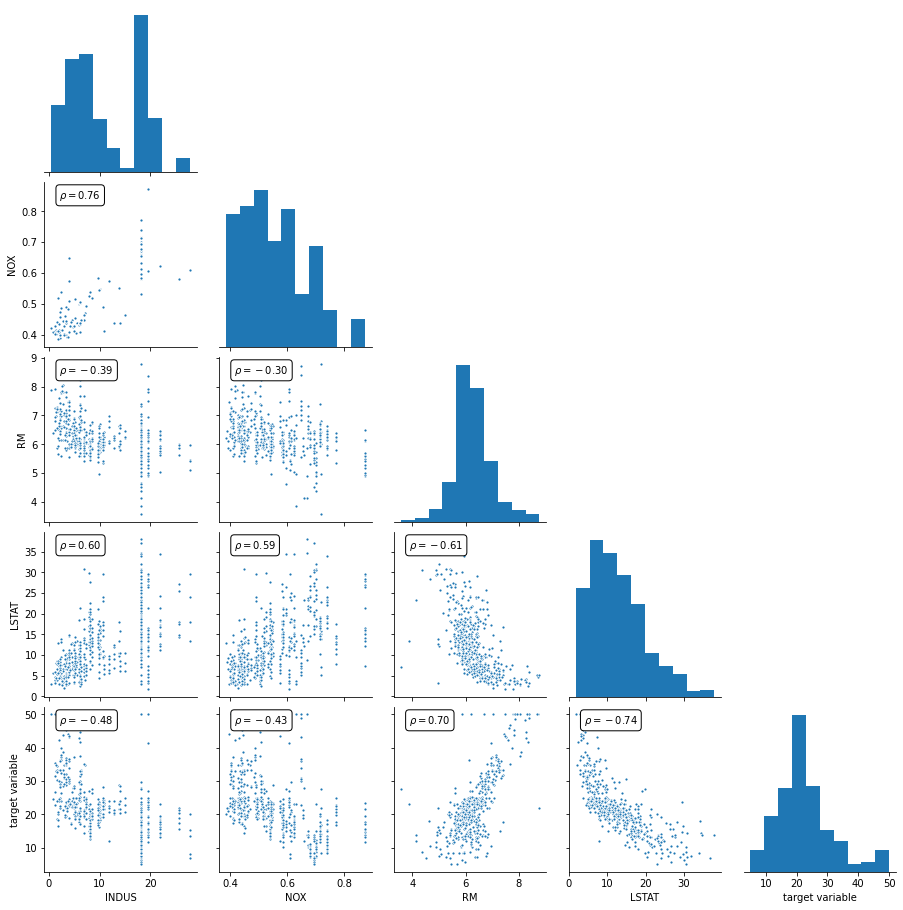

In [5]:
def corrfunc(x,y, ax=None, **kws):
    
    r, _ = stats.pearsonr(x, y)
    ax = ax or plt.gca()

    ax.annotate(
        r'$\rho' + f'= {r:.2f}$',
        xy=(.1, .9),
        xycoords=ax.transAxes,
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            boxstyle='round, pad=0.35'
        )
    )

g = sns.pairplot(
    pd.DataFrame(
        data=np.hstack( (X_new, y.reshape(-1, 1)) ),
        columns=labels_new.tolist()+['target variable']
    ),
    markers=".", 
    corner=True,
)

g.map_lower(corrfunc)

plt.show()

## Creating a pipeline

scikit provides a Pipeline class, which serves to nest a sequence of transformations and a final estimator. With this, we can automate the date transformation steps for an estimator.

Let's do the variable selection step and fit an ITEA regressor into a pipeline. 

In [6]:
tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)), 
    'id'       : lambda x: x,
    'exp'      : np.exp
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'exp'      : np.exp,
}

# Creating our ITEA regressor instance
itea = ITEA_regressor(
    gens         = 75,
    popsize      = 75,
    expolim      = (-2, 2),
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    verbose      = 10,
    labels       = labels_new
)

pipeline = Pipeline([
    ('selectKbest', feature_selector),
    ('itea', itea)
])

pipeline.fit(X_train, y_train)

gen | smallest fitness | mean fitness | highest fitness | remaining time (s)
----------------------------------------------------------------------------
  0 |         4.573795 |     5.714874 |        9.375262 | 0min5seg    
 10 |         4.214950 |     4.424472 |        4.674913 | 0min7seg    
 20 |         4.115971 |     4.273584 |        4.793133 | 0min6seg    
 30 |         4.063605 |     4.239906 |        4.974304 | 0min6seg    
 40 |         4.038955 |     4.357048 |        5.486643 | 0min4seg    
 50 |         3.910157 |     4.131794 |        4.766535 | 0min3seg    
 60 |         3.939110 |     4.234033 |        5.430637 | 0min3seg    
 70 |         3.919133 |     4.065749 |        5.638608 | 0min1seg    


Pipeline(steps=[('selectKbest',
                 SelectKBest(k=4,
                             score_func=<function mutual_info_regression at 0x7f9fb937d0e0>)),
                ('itea',
                 ITEA_regressor(gens=75,
                                labels=array(['INDUS', 'NOX', 'RM', 'LSTAT'], dtype='<U7'),
                                popsize=75,
                                tfuncs={'exp': <ufunc 'exp'>,
                                        'id': <function <lambda> at 0x7f9fa792bef0>,
                                        'log': <ufunc 'log'>,
                                        'sqrt.abs': <function <lambda> at 0x7f9fa792be60>},
                                tfuncs_dx={'exp': <ufunc 'exp'>,
                                           'id': <function <lambda> at 0x7f9fa7936290>,
                                           'log': <function <lambda> at 0x7f9fa7936170>,
                                           'sqrt.abs': <function <lambda> at 0x7f9fa7936200>},

We can access the Pipeline ITEA with the index operator. Let's save the ITEA in one variable, and let's save the final expression (``ITExpr_regressor``) in another. Finally, let's look at the final expression.

In [7]:
print(pipeline['itea'].bestsol_)

1155.618*sqrt.abs(INDUS^-1 * RM^-2) + -52613.008*sqrt.abs(INDUS^-1 * NOX^-2 * RM^-2 * LSTAT^-1) + 779.536*sqrt.abs(NOX^-2 * LSTAT^-1) + 4757.868*sqrt.abs(INDUS^-1 * RM^-2 * LSTAT^-1) + 5.162*sqrt.abs(NOX^2 * RM^-1) + -24.448


## Finetuning with gridsearch

ITEA has several hyperparameters, and although the method can be used with default values (which deliver fast execution with satisfactory results), it may be necessary to further investigate a suitable configuration for the domain of the problem in which the regressor is being applied.

Imagine we want to limit the final expression to something that isn't too complex. We can achieve this by several ways.

We can have several expression sizes, exponents limits, and different transformation functions. Let's choose some values for each configuration to perform the gridsearch.

Here, we'll look to find a subset of functions and exponents that, combined, deliver good performance in the dataset we're using.

Gridsearch can receive either an estimator or a pipeline to make the adjustment.

A detail that is worth mentioning is that, in the case of a Pipeline, the variables will have a name with a prefix to be used in gridsearch.

In [8]:
from itertools import permutations

two_tfuncs = permutations(['log', 'sqrt.abs', 'exp'], r=2)

parameters = {
    'itea__gens'      : [100],
    'itea__popsize'   : [100],
    'itea__tfuncs_dx' : [tfuncs_dx],
    'itea__expolim'   : [(-2, 2), (-1, 1), (0, 1), (0, 2)],
    'itea__max_terms' : [10],
    'itea__tfuncs'    : [
        {t1:tfuncs[t1], t2:tfuncs[t2], 'id':tfuncs['id']}
        for (t1, t2) in set(two_tfuncs)
    ],
    'itea__verbose': [False]
}

The scikit provides GridSearchCV, a method that does an exhaustive search for the best configuration by cross-validating past data.

Since ITEA is an evolutionary algorithm, exhaustive testing can be computationally expensive. Let's use HalvingGridSearchCV (which is in experimental stage at the time of creation of this notebook), imported at the beginning of the notebook.

This method makes the gridsearch with several interactions, but allocating few resources for the first runs, in order to get a possible direction of where it should apply more effort to obtain the best configuration.

To use the standard gridsearch, just change ``HalvingGridSearchCV`` to ``GridSearchCV``.

In [9]:
gridsearch = HalvingGridSearchCV(
    estimator=pipeline,
    param_grid=parameters,
    verbose=2, 
    n_jobs=-1,
    refit=True, # If true, then 'gridsearch' will have a best_estimator_
    cv=3,
    factor=2,
    scoring='neg_root_mean_squared_error'
)

t_start = time.time()

gridsearch.fit(X_train, y_train)

t_end = time.time() - t_start

print('----------')
print(f'{round(t_end, 2)} seconds')

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 21
max_resources_: 339
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 24
n_resources: 21
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 1
n_candidates: 12
n_resources: 42
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 2
n_candidates: 6
n_resources: 84
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 3
n_resources: 168
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 4
n_candidates: 2
n_resources: 336
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
645.48 seconds


Now that we have the best result, let's preview the grid of different settings for exponent limits and subsets of transform functions, and let's also create a final model with the best found setting.

The heatmap is based on [this example from the scikits' documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html#sphx-glr-auto-examples-model-selection-plot-successive-halving-heatmap-py).

[[-156.84325902 -687.56300357   -5.09552045  -90.20634561]
 [-144.96714443 -158.95613307   -7.92401372  -12.60989396]
 [-104.2388729  -253.00669573  -69.81169549  -63.51776869]
 [-123.8339485    -8.37051732  -15.85467758   -4.0033369 ]
 [ -69.34306521  -94.89337417   -9.84171143  -11.37024497]
 [ -66.818454    -67.6153272   -19.47674466   -4.83821689]]


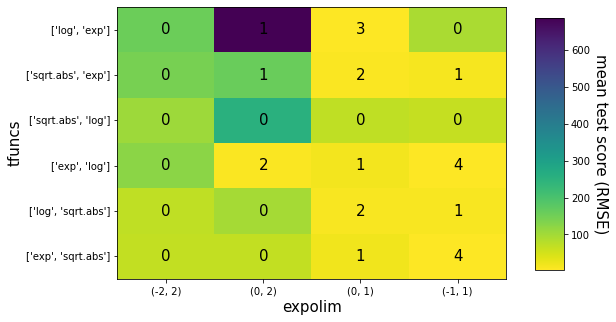

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

results_aux = gridsearch.cv_results_.copy()
    
# One of the parameters is a dictionary, the other a tuple. When we create a data frame
# with this, it ends up becoming a mess when the pandas parser handles these values.
# Let's turn it into strings.
results_aux['param_itea__tfuncs']  = [
    str(list(k.keys())[:-1]) # Left out the 'id' tfunc
    for k in results_aux['param_itea__tfuncs']]

results_aux['param_itea__expolim'] = [
    str(k)
    for k in results_aux['param_itea__expolim']]

results = pd.DataFrame.from_dict(results_aux)

scores_matrix = results.sort_values('iter').pivot_table(
    index   = 'param_itea__tfuncs',
    columns = 'param_itea__expolim',
    values  = 'mean_test_score',
    aggfunc = 'last'
)

print(scores_matrix.values)

im = ax.imshow(scores_matrix*-1, aspect='auto', cmap='viridis_r')

expolims_gs = set(results_aux['param_itea__expolim'])
ax.set_xlabel('expolim', fontsize=15)
ax.set_xticks(np.arange(len(expolims_gs)))
ax.set_xticklabels(expolims_gs)

tfuncs_gs = set(results_aux['param_itea__tfuncs'])
ax.set_ylabel('tfuncs', fontsize=15)
ax.set_yticks(np.arange(len(tfuncs_gs)))
ax.set_yticklabels(tfuncs_gs)

iterations = results.pivot_table(
    index='param_itea__tfuncs',
    columns='param_itea__expolim',
    values='iter',
    aggfunc='max'
).values

for i in range(len(tfuncs_gs)):
    for j in range(len(expolims_gs)):
        ax.text(j, i, iterations[i, j],
            ha="center", va="center", color="k", fontsize=15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel(
    'mean test score (RMSE)', rotation=-90,
    va="bottom", fontsize=15)
    
plt.show()

## Creating and fitting a model with the best configuration

Finally, let's create an instance of ITEA with the best configuration, and then use the test data to see how the final model performs as a predictor.

Additionally, let's look at some interpretability graphs.

In [11]:
# best_pipeline is be a pipeline!
best_pipeline = gridsearch.best_estimator_

# predict(), score() and other estimators methods will
# perform the transformations and then call the method on the final
# estimator.

best_pipeline.score(X_test, y_test)

0.7949394696561386

ITEA is an estimator, and the interpretability classes only work with instances of ``ITEA`` or ``ITExpr``.

To be able to use the entire pipeline created, let's create a method that receives a pipeline and iterates over all transformations successively until finishing the treatment, and returning this new data.

So we'll use this method to handle the data before calling the ``fit`` of the explainers. Thus, we use the pipeline with the classes from ``itea.inspection``.

In [12]:
def just_transformers(pipeline, X):
    
    Xt = X.copy()
    for name, transformer in pipeline.steps[:-1]:
        Xt = transformer.transform(Xt)
        
    return Xt

Let's create the explainer instance. We'll pass an ``ITExpr`` to the explainer and use the transformations to fit the data. Note how these values are used.

In [13]:
explainer = ITExpr_explainer(
    itexpr    = best_pipeline['itea'].bestsol_,
    tfuncs    = tfuncs,
    tfuncs_dx = tfuncs_dx
).fit(just_transformers(best_pipeline, X_train), y_train)

Now we can create the interpretability plots we saw on the other notebooks.

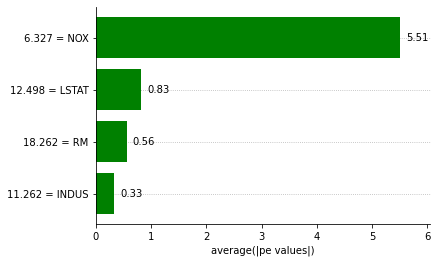

In [14]:
explainer.plot_feature_importances(
    X=just_transformers(best_pipeline, X_train),
    importance_method='pe',
    grouping_threshold=0.0,
    barh_kw={'color':'green'}
)

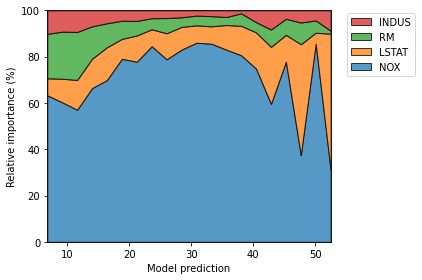

In [15]:
explainer.plot_normalized_partial_effects(grouping_threshold=0.1, show=False)

plt.tight_layout()

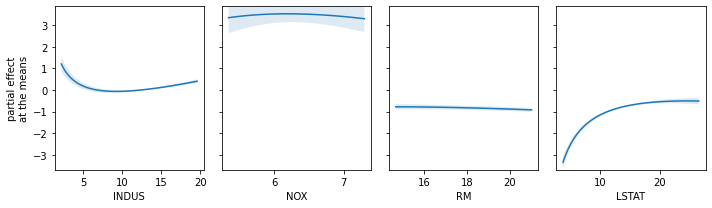

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

explainer.plot_partial_effects_at_means(
    X=just_transformers(best_pipeline, X_test),
    features=range(4),
    ax=axs,
    num_points=100,
    share_y=True,
    show_err=True,
    show=False
)

plt.tight_layout()
plt.show()